In [1]:
from clipppy import load_config
from matplotlib import pyplot as plt
import torch, pyro, numpy as np 
import collections, os
import corner
from ruamel.yaml import YAML

import sys
sys.path.append('/home/eliasd/lensing/elias_utils')
from plotting import *

In [2]:
VERSION_NAME = '1510_3'


STORE_DIR = 'training_data_lens'
os.makedirs(STORE_DIR, exist_ok = True)

PARAMS = YAML().load(open('params.yaml'))['lens']

In [3]:
losses_name = os.path.join(STORE_DIR, f'losses_{VERSION_NAME}.pt')
guide_name  = os.path.join(STORE_DIR, f'guide_{VERSION_NAME}.pt')

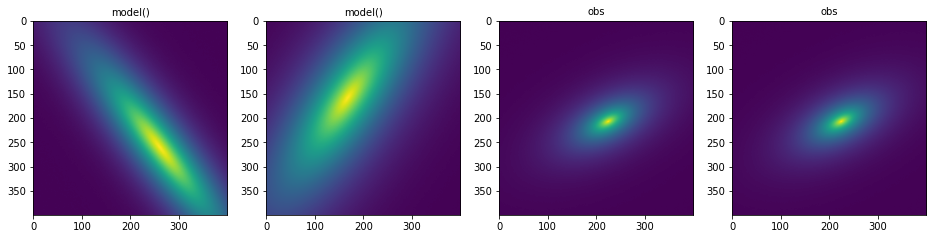

In [4]:
config = load_config('config_fit_lens.yaml')
model = config.umodel
obs = config.conditioning['obs']

plot_imshow([model(), model(), obs, obs], size_y = 4, titles = ['model()', 'model()', 'obs', 'obs'])

In [5]:
guide = config.guide

guide.setup()

guide

Guide(
  (MultivariateNormal): MultivariateNormalSamplingGroup(7 sites, torch.Size([7]))
)

In [6]:
if not os.path.isfile(guide_name):
    print('Training!')

    guide.train() 
    # losses += config.fit(lr=1e-2, n_steps=1000)
    # losses, lrs = config.fit()
    losses = config.fit()
    
    torch.save(losses, losses_name)
    torch.save(guide, guide_name)

else: 
    print('Already traied!')

print('Loading!')
guide = config.guide = torch.load(guide_name)
losses = torch.load(losses_name)

Already traied!
Loading!


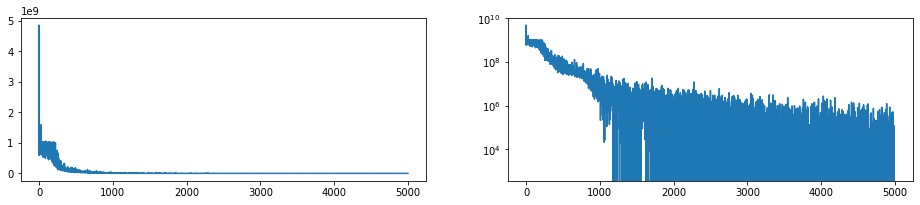

In [7]:
plot_log(losses, size_y = 3)

In [8]:
with pyro.plate('plate', 100000):
    ppd = config.guide()

param_names = []
for k, v in ppd.items():
    ppd[k] = v.detach().numpy()
    param_names.append(k)
    
params = PARAMS['truth']
truths = [params.get(k, None) for k in ppd.keys()]

mode = params.copy()
for param_name in param_names:
    y, x = np.histogram(ppd[param_name], bins = 50)
    mode[param_name] = (x[np.where(y == y.max())])[0]
    
mean = params.copy()
for k, v in ppd.items():
    mean[k] = v.mean()


x	truth 0.30000, mode 0.29091, mean 0.29138
y	truth 0.10000, mode 0.10542, mean 0.10650
phi	truth 1.10000, mode 1.09974, mean 1.09958
q	truth 0.50000, mode 0.50147, mean 0.50169
index	truth 1.10000, mode 1.09988, mean 1.10019
r_e	truth 0.90000, mode 0.89808, mean 0.90001
I_e	truth 1.50000, mode 1.49234, mean 1.49393


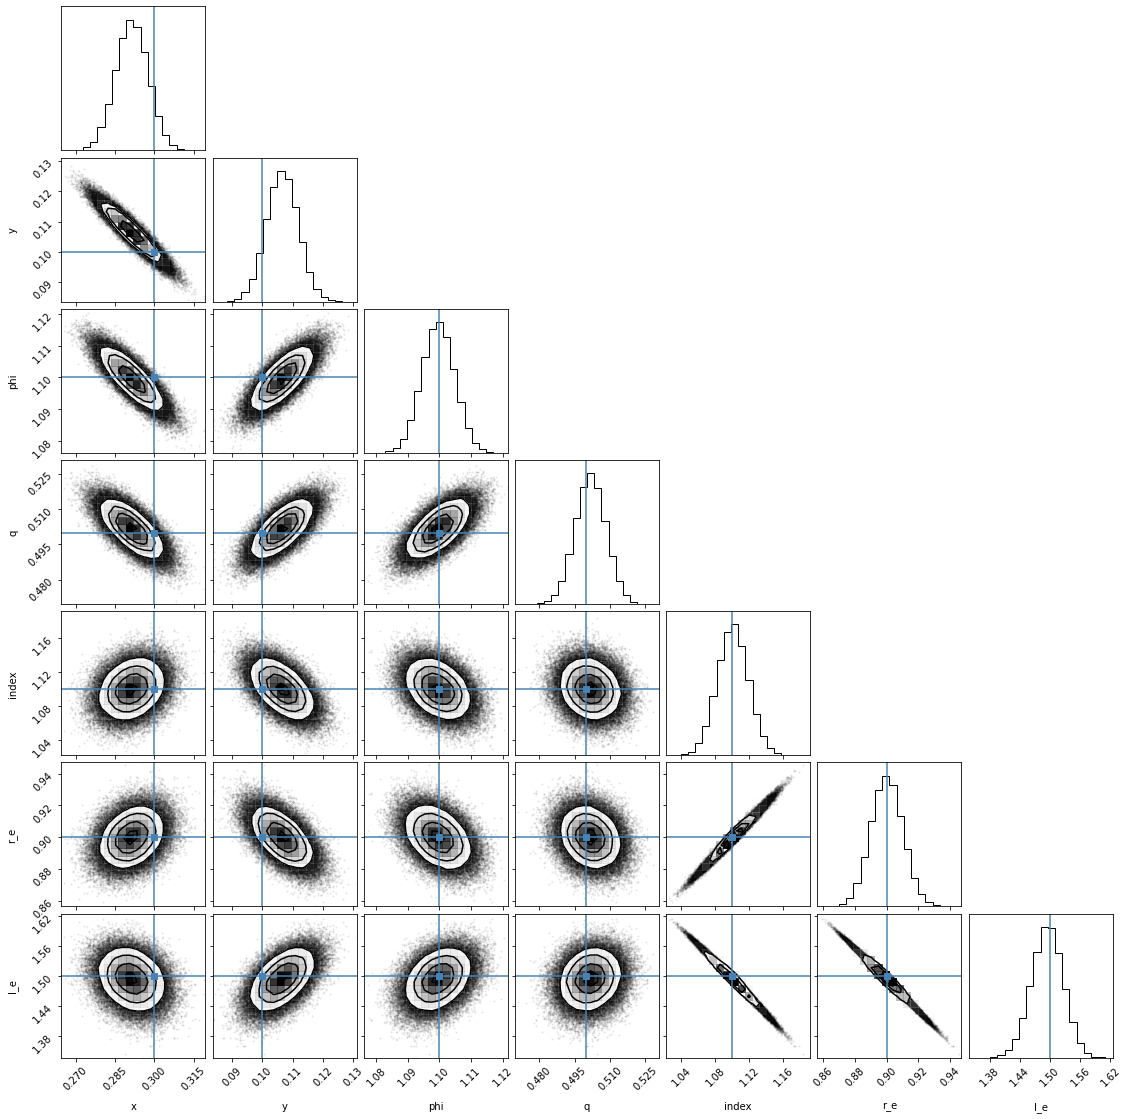

In [9]:
for k, v in ppd.items(): 
    print(f'{k}\ttruth {params[k]:.5f}, mode {mode[k]:.5f}, mean {mean[k]:.5f}')
corner.corner( np.stack(list(ppd.values()), -1), truths = truths, labels = param_names);

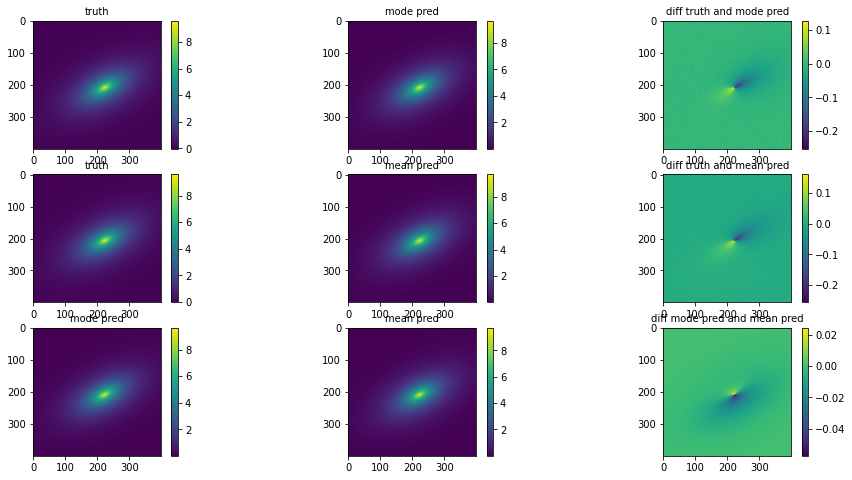

In [10]:
sersic = SersicSource()
X, Y = get_meshgrid(0.0125, 400, 400)
mode_pred = sersic(X, Y, x = mode['x'], y = mode['y'], phi = mode['phi'], q = mode['q'], index = mode['index'], r_e = mode['r_e'], I_e = mode['I_e'])
mean_pred = sersic(X, Y, x = mean['x'], y = mean['y'], phi = mean['phi'], q = mean['q'], index = mean['index'], r_e = mean['r_e'], I_e = mean['I_e'])

plots = [obs, mode_pred, mode_pred-obs, obs, mean_pred, mean_pred-obs, mode_pred, mean_pred, mode_pred - mean_pred]
titles = ['truth', 'mode pred', 'diff truth and mode pred', 'truth', 'mean pred', 'diff truth and mean pred', 'mode pred', 'mean pred', 'diff mode pred and mean pred']
plot_imshow(plots = plots, nrows = 3, colorbar = True, titles = titles)